<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Calcular_Beta_A%C3%A7%C3%B5es_e_Portf%C3%B3lio_v1_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar as bibliotecas necessárias

In [1]:
!pip install -U yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.21
    Uninstalling yfinance-0.2.21:
      Successfully uninstalled yfinance-0.2.21


In [2]:
import pandas as pd
from datetime import date, timedelta, time
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


# Definir as ações e período histórico

In [3]:
############################ ATENÇÃO ###############################
####################################################################
# Definir quais ações serão baixadas
# As ações brasileiras devem ter '.SA' no final
tickers = "ITSA4.SA", "ABEV3.SA", "BBDC4.SA", "BOVA11.SA"

# Definir data de início e fim da série (ATENÇÃO AO FORMATO "AAAA-MM-DD")
data_inicio = "2020-01-01"
data_fim    = date.today()
################################################################
################################################################
# print(data_inicio," : ", data_fim)


### Baixar os preços das ações

In [4]:
precos = pd.DataFrame()

for i in tickers:
  ticker = yf.Ticker(i)
  precos[i] = ticker.history(start=data_inicio, end=data_fim)["Close"]


### Renomear as colunas

In [5]:
novo_nome = []
for i in range(len(tickers)):
  elemento = str(tickers[i][:tickers[i].find('.SA')]) # elimina o '.SA'
  novo_nome.append(elemento)

precos.columns = novo_nome
# precos

### Padronizar os preços na base 100

In [6]:
precos_100 = (precos/precos.iloc[0]*100) # trava no primeiro registro da série
# preco_100.head()


## Plotar o gráfico de comparação dos ativos

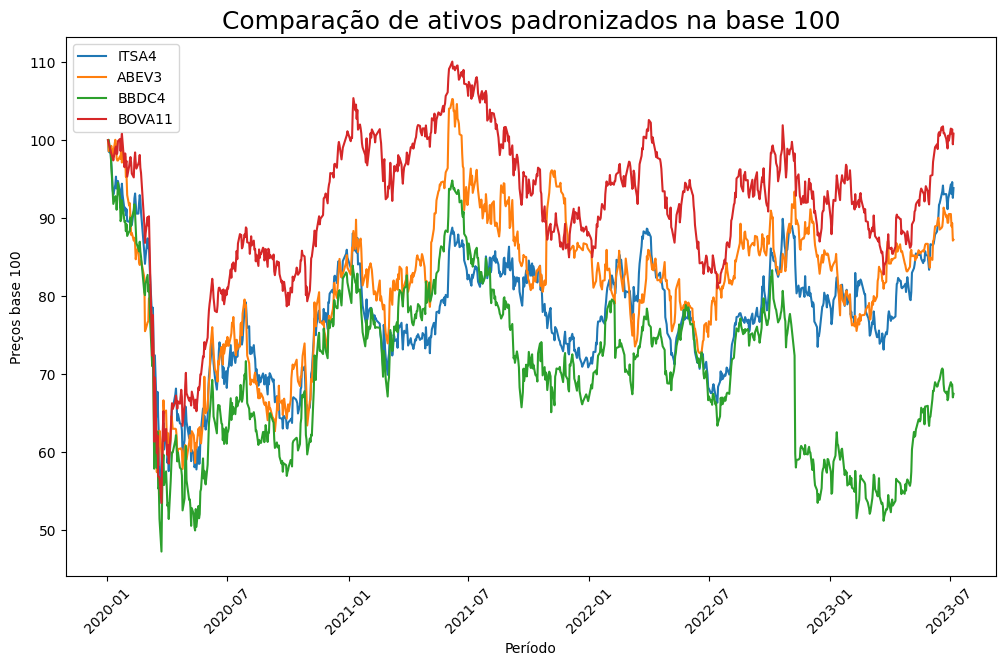

In [7]:
df_100 = precos_100
fig, ax = plt.subplots(figsize=[12, 7])

for col in df_100.columns:
  plt.plot(df_100[col], label=col) # label com a coluna do dataframe

plt.xticks(rotation=45)
ax.set_title('Comparação de ativos padronizados na base 100', fontsize=18)
ax.set_xlabel('Período')
ax.set_ylabel('Preços base 100')
plt.legend()
plt.show()

# Calcular os retornos das ações

In [9]:
retornos = precos.pct_change().dropna() # retirar registros com 'NaN'
# retornos.head()
retornos_log = np.log(precos/precos.shift(1)).dropna()
# retornos_log.head()


# Função para calcular o beta de um ativo em relação ao índice



$$ \beta = \frac{{\text{cov}(r_i, r_m)}}{{\text{var}(r_m)}} $$

onde:

- &#946; é o beta do ativo
- r<sub>i</sub> é o retorno do ativo,
- r<sub>m</sub> é o retorno do mercado,

Essa fórmula representa o cálculo do beta de um ativo em relação a um índice de mercado. O beta mede a sensibilidade do ativo em relação às variações do mercado. Um beta maior que 1 indica que o ativo tende a ser mais volátil que o mercado, enquanto um beta menor que 1 indica que o ativo tende a ser menos volátil que o mercado.

## Calcular o beta de cada ativo em relação ao índice

In [10]:
def calcular_beta(returns_asset, returns_market):
  """
  Calcula o beta de um ativo em relação ao índice de mercado.

  Parâmetros:
  - returns_asset: retornos do ativo
  - returns_market: retornos do índice de mercado

  Retorna o valor do beta.
  """
  # Calcula a covariância entre os retornos da ação e do mercado
  covariance = np.cov(returns_asset, returns_market)[0, 1]
  # Calcula a variância dos retornos do mercado
  variance_market = np.var(returns_market)
  # Calcula o beta como a covariância dividida pela variância do mercado
  beta = covariance / variance_market

  return beta


## Função para calcular o beta da carteira

In [11]:
df = retornos_log

# Seleciona os retornos das ações e do índice
returnos_bova11 = df['BOVA11']

# Dicionário para armazenar os betas de cada ativo
betas = {}

# Percorre as colunas do DataFrame para calcular o beta de cada ativo
for col in df.columns:
    if col != 'BOVA11':
        returnos_ativo = df[col]
        beta_ativo = calcular_beta(returnos_ativo, returnos_bova11)
        betas[col] = beta_ativo

# Cria um novo DataFrame com os betas
df_betas = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])
print(df_betas)


           Beta
ITSA4  0.857492
ABEV3  0.689968
BBDC4  1.063082


# Calcular o beta da carteira

In [14]:
# Função para calcular o beta da carteira
def calcular_beta_carteira(df, proporcoes=None):
  """
  Calcula o beta da carteira com base nos betas dos ativos e suas proporções.

  Parâmetros:
  - df: DataFrame contendo os betas dos ativos
  - proporcoes: lista opcional com as proporções de cada ativo na carteira

  Retorna o valor do beta da carteira.
  """

  betas = df['Beta'].tolist()  # Obtém os betas do DataFrame
  if proporcoes is None:
      proporcoes = [1 / len(betas)] * len(betas)  # Proporções iguais caso não sejam fornecidas
  else:
      # Verifica se a soma das proporções é igual a 1
      soma_proporcoes = sum(proporcoes)
      if soma_proporcoes != 1:
          print('Alerta: A soma das proporções DEVE SER igual a 1.')
          return None

  beta_carteira = sum(beta * proporcao for beta, proporcao in zip(betas, proporcoes))
  print('Betas:', betas)
  print('Proporções:', proporcoes)

  return beta_carteira

##################################################################
proporcoes = [0.20, 0.50, 0.30]  # Digite o peso de cada ativo
##################################################################

beta_carteira = calcular_beta_carteira(df_betas, proporcoes)

if beta_carteira is not None:
    print('Beta da Carteira:', beta_carteira)


Betas: [0.8574923970446205, 0.6899680122287852, 1.0630818787478697]
Proporções: [0.2, 0.5, 0.3]
Beta da Carteira: 0.8354070491476777
